### IMPORTING PACKAGES

In [43]:
import pandas as pd
import numpy as np
import json

import seaborn as sns

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import precision_score, f1_score, accuracy_score, confusion_matrix, recall_score

# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer

#for word embedding
from gensim.models import Word2Vec #Word2Vec is mostly used for huge datasets

#for huggingface datasets
from datasets import load_dataset

import json

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\guilf\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\guilf\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\guilf\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\guilf\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading Data

### Dataset 1 - dair-ai/emotion

In [44]:
# CLASS DISTRIBUTION 
# 0 sadness
# 1 joy
# 2 love
# 3 anger
# 4 fear
# 5 surprise

dataset_emotion = load_dataset("dair-ai/emotion")

# Convert the dataset to a Pandas DataFrame
dataset2 = pd.DataFrame(dataset_emotion['train'])

# Removing class 2 (love)
label_to_remove = 2
dataset2 = dataset2[dataset2['label'] != label_to_remove]
dataset2 = dataset2.reindex(["label", "text"], axis=1)

# Print the shape and head of the DataFrame
print(dataset2.shape)
print(dataset2.head())
print(dataset2['label'].value_counts())




c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\datasets\load.py:1461: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


(14696, 2)
   label                                               text
0      0                            i didnt feel humiliated
1      0  i can go from feeling so hopeless to so damned...
2      3   im grabbing a minute to post i feel greedy wrong
4      3                               i am feeling grouchy
5      0  ive been feeling a little burdened lately wasn...
label
1    5362
0    4666
3    2159
4    1937
5     572
Name: count, dtype: int64


### Dataset 2 - empathetic_dialogues

In [45]:
dataset_empathetic_dialogues = load_dataset("empathetic_dialogues")

# Convert the dataset to a Pandas DataFrame
df_train_empathetic = pd.DataFrame(dataset_empathetic_dialogues['train'])


In [46]:
unique_values = df_train_empathetic['context'].unique()
print("Total",unique_values.size)
print(unique_values)

Total 32
['sentimental' 'afraid' 'proud' 'faithful' 'terrified' 'joyful' 'angry'
 'sad' 'jealous' 'grateful' 'prepared' 'embarrassed' 'excited' 'annoyed'
 'lonely' 'ashamed' 'guilty' 'surprised' 'nostalgic' 'confident' 'furious'
 'disappointed' 'caring' 'trusting' 'disgusted' 'anticipating' 'anxious'
 'hopeful' 'content' 'impressed' 'apprehensive' 'devastated']


In [47]:

# Print the shape and head of the DataFrame
# print(df_train_empathetic.shape)
# print(df_train_empathetic.head())

# Print the shape and head of the DataFrame
df_context_prompt = df_train_empathetic[['context', 'prompt']]
df_unique_prompt = df_context_prompt.drop_duplicates(subset=['prompt'])

# print(df_unique_prompt.shape)
# print(df_unique_prompt.head())

target_emotions = ['joyful', 'surprised', 'angry', 'sad', 'terrified', 'afraid', 'content']

# Filter the DataFrame based on the specified emotions
dataset1 = df_unique_prompt[df_unique_prompt['context'].str.contains('|'.join(target_emotions), case=False)]
dataset1 = dataset1.rename(columns={'context': 'label', 'prompt': 'text'})

print(dataset1.shape)
print(dataset1.head())

(4347, 2)
        label                                               text
6      afraid                       i used to scare for darkness
21  terrified  A recent job interview that I had made me feel...
26     joyful  I am very happy to have been first over 300 st...
30      angry                    I once lost my job and got mad.
34        sad  One year during christmas_comma_ i did not get...


In [48]:
# Mapping emotions to respective classes
mapping_emotions = {
    'sad': 0,
    'joyful': 1,
    'angry': 3,
    'terrified' : 4,
    'afraid' : 4,
    'surprised': 5,
    'content' : 6
}

dataset1['label'] = dataset1['label'].map(mapping_emotions)
print(dataset1.shape)
print(dataset1.head())
print(dataset1['label'].value_counts())


(4347, 2)
    label                                               text
6       4                       i used to scare for darkness
21      4  A recent job interview that I had made me feel...
26      1  I am very happy to have been first over 300 st...
30      3                    I once lost my job and got mad.
34      0  One year during christmas_comma_ i did not get...
label
4    1141
5     918
3     621
0     602
1     552
6     513
Name: count, dtype: int64


### Dataset 3 - https://github.com/SannketNikam/Emotion-Detection-in-Text  (not used)

In [49]:
csv_path = 'data/emotion_dataset.csv'
df_emotion_original = pd.read_csv(csv_path)

In [50]:
dataset3 = df_emotion_original.copy()

dataset3.drop(columns=['Unnamed: 0'], inplace=True)
dataset3.drop(columns=['Text'], inplace=True)
dataset3.dropna(inplace=True)

unique_values = dataset3['Emotion'].unique()
print("Total",unique_values.size)
print(unique_values)

x=dataset3['Emotion'].value_counts()
print(x)

dataset3.head()

Total 8
['joy' 'sadness' 'fear' 'surprise' 'anger' 'shame' 'neutral' 'disgust']
Emotion
joy         11037
sadness      6719
fear         5409
anger        4286
surprise     4062
neutral      1811
disgust       856
shame         146
Name: count, dtype: int64


,Emotion,Clean_Text
1,joy,Sage Act upgrade list tommorow
2,sadness,WAY HOMEGIRL BABY FUNERAL MAN HATE FUNERALS SH...
3,joy,eye true hazel eyeand brilliant Regular feat...
4,joy,ugh babe hugggzzz u babe naamazed nga ako e...
5,fear,Im expecting extremely important phonecall min...


In [51]:
# Mapping emotions to respective classes
mapping_emotions = {
    'sadness': 0,
    'joy': 1,
    'anger': 3,
    'fear' : 4,
    'surprise': 5,
    'neutral' : 6
}

dataset3['Emotion'] = dataset3['Emotion'].map(mapping_emotions)
print(dataset3.shape)
print(dataset3['Emotion'].value_counts())

(34326, 2)
Emotion
1.0    11037
0.0     6719
4.0     5409
3.0     4286
5.0     4062
6.0     1811
Name: count, dtype: int64


In [52]:
dataset3 = dataset3.rename(columns={'Emotion': 'label', 'Clean_Text': 'text'})
print(dataset3)

       label                                               text
1        1.0                     Sage Act upgrade list tommorow
2        0.0  WAY HOMEGIRL BABY FUNERAL MAN HATE FUNERALS SH...
3        1.0  eye  true hazel eyeand brilliant  Regular feat...
4        1.0    ugh babe hugggzzz u  babe naamazed nga ako e...
5        4.0  Im expecting extremely important phonecall min...
...      ...                                                ...
34787    5.0         gift Hope like it hand wear  Itll warm Lol
34788    1.0         world didnt meso world DEFINITELY cnt away
34789    3.0                                  man robbed today 
34790    4.0                          Youu JEALOUSY #Losing YOU
34791    0.0                              think baby dream time

[34326 rows x 2 columns]


### Dataset 4 - https://doraemon.iis.sinica.edu.tw/emotionlines/index.html

In [53]:
# Assuming json_data is your JSON object
json_data_train = json.load(open('data/friends_train.json'))
json_data_test = json.load(open('data/friends_test.json'))
json_data_dev = json.load(open('data/friends_dev.json'))

# Flatten the data
flattened_data_train = [item for sublist in json_data_train for item in sublist]
flattened_data_test = [item for sublist in json_data_test for item in sublist]
flattened_data_dev = [item for sublist in json_data_dev for item in sublist]

# Convert to DataFrame
dataset4_train = pd.json_normalize(flattened_data_train)
dataset4_test = pd.json_normalize(flattened_data_test)
dataset4_dev = pd.json_normalize(flattened_data_dev)

# Convert to CSV
dataset4_train.to_csv('data/friends_train.csv', index=False)
dataset4_test.to_csv('data/friends_test.csv', index=False)
dataset4_dev.to_csv('data/friends_dev.csv', index=False)

dataset4_train.head()

,speaker,utterance,emotion,annotation
0,Chandler,also I was the point person on my companys tr...,neutral,4100000
1,The Interviewer,You mustve had your hands full.,neutral,5000000
2,Chandler,That I did. That I did.,neutral,5000000
3,The Interviewer,So lets talk a little bit about your duties.,neutral,5000000
4,Chandler,My duties? All right.,surprise,2000030


In [54]:
dataset4_train.drop(columns=['speaker','annotation'], inplace=True)
dataset4_train.dropna(inplace=True)

dataset4_train = dataset4_train.rename(columns={'emotion': 'label', 'utterance': 'text'})

dataset4_train.head()

,text,label
0,also I was the point person on my companys tr...,neutral
1,You mustve had your hands full.,neutral
2,That I did. That I did.,neutral
3,So lets talk a little bit about your duties.,neutral
4,My duties? All right.,surprise


label
neutral        4752
non-neutral    2017
joy            1283
surprise       1220
anger           513
sadness         351
disgust         240
fear            185
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

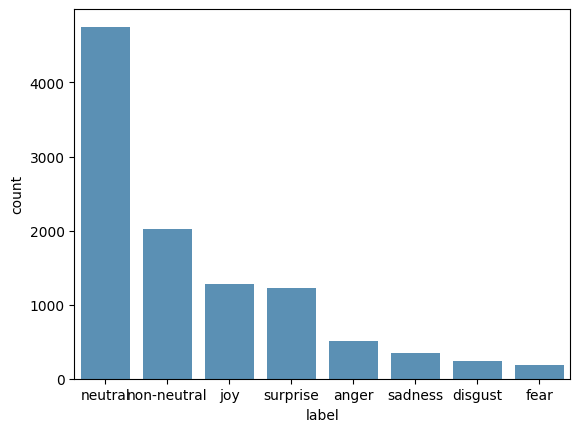

In [55]:
x=dataset4_train['label'].value_counts()
print(x)
sns.barplot(x=x.index, y=x, alpha=0.8)

In [56]:
# Mapping emotions to respective classes
mapping_emotions = {
    'sadness': 0,
    'joy': 1,
    'anger': 3,
    'fear' : 4,
    'surprise': 5,
    'neutral' : 6
}

dataset4_train['label'] = dataset4_train['label'].map(mapping_emotions)
print(dataset4_train.shape)
print(dataset4_train['label'].value_counts())


(10561, 2)
label
6.0    4752
1.0    1283
5.0    1220
3.0     513
0.0     351
4.0     185
Name: count, dtype: int64


## EDA
Now lets concat all three datasets

label
joyful       7197
sad          5619
neutral      5265
angry        3293
fearful      3263
surprised    2710
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

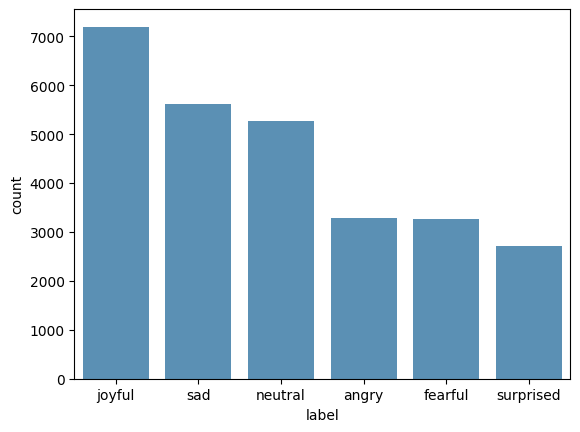

In [57]:
# Final emotions to use:
# 'sad': 0,
# 'joyful': 1,
# 'angry': 3,
# 'fearful' : 4,
# 'surprised': 5,
# 'neutral' : 6
df_train = pd.concat([dataset1, dataset2, dataset4_train], axis=0)

#Missing values
df_train.isna().sum()
df_train.dropna(inplace=True)


df_train_mapped = df_train.copy()
mapping_emotions = {
    0:'sad',
    1:'joyful',
    3:'angry',
    4:'fearful',
    5:'surprised',
    6:'neutral'
}

df_train_mapped['label'] = df_train_mapped['label'].map(mapping_emotions)
x=df_train_mapped['label'].value_counts()
print(x)
sns.barplot(x=x.index, y=x, alpha=0.8)

In [58]:
df_train.head()

,label,text
6,4.0,i used to scare for darkness
21,4.0,A recent job interview that I had made me feel...
26,1.0,I am very happy to have been first over 300 st...
30,3.0,I once lost my job and got mad.
34,0.0,One year during christmas_comma_ i did not get...


## Balace Dataset

We decided to keep only 2700 lines for each label.

In [59]:
# Group DataFrame by 'label'
grouped = df_train.groupby('label')

# Initialize an empty list to store filtered DataFrames
dfs = []

# Iterate over each group
for label, group in grouped:
    # Check if there are more than 2700 rows for the label
    if len(group) > 2700:
        # Randomly select 2700 rows
        sample = group.sample(n=2700, random_state=42)  # Adjust random_state as needed for reproducibility
        dfs.append(sample)
    else:
        # If there are fewer than 2700 rows, keep all rows
        dfs.append(group)

# Concatenate the filtered DataFrames back into a single DataFrame
balanced_df = pd.concat(dfs)

# Now, balanced_df contains 2700 rows for each label (if available) with rows randomly selected
balanced_df['label'].value_counts()
balanced_df.head()

,label,text
12169,0.0,i feel like ive been defeated
8601,0.0,i feel a little pained but that will probably ...
7717,0.0,My dog is missing. We have been looking for he...
4709,0.0,ive never thought i would feel so guilty for t...
5007,0.0,"Without, without these arms, and your face, an..."


label
sad          2700
joyful       2700
angry        2700
fearful      2700
surprised    2700
neutral      2700
Name: count, dtype: int64


<Axes: xlabel='label', ylabel='count'>

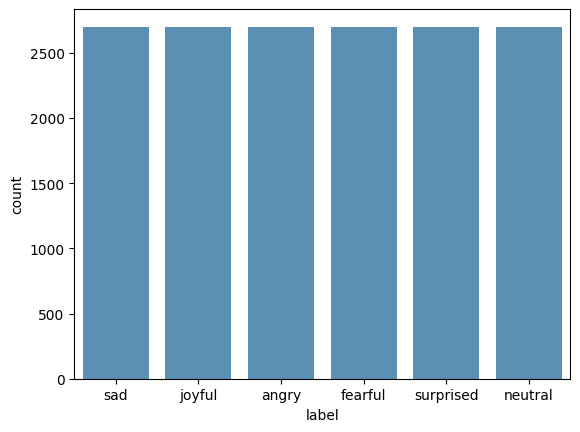

In [60]:
balanced_df_mapped = balanced_df.copy()
balanced_df_mapped['label'] = balanced_df_mapped['label'].map(mapping_emotions)
x=balanced_df_mapped['label'].value_counts()
print(x)
sns.barplot(x=x.index, y=x, alpha=0.8)

In [61]:
# 'sad': 0,
# 'joyful': 1,
# 'angry': 3,
# 'fearful' : 4,
# 'surprised': 5,
# 'neutral' : 6

#1. WORD-COUNT
print("WORD-COUNT")
df_train['word_count'] = df_train['text'].apply(lambda x: len(str(x).split()))
print(df_train[df_train['label']==0]['word_count'].mean()) #sadness
print(df_train[df_train['label']==1]['word_count'].mean()) #joy
print(df_train[df_train['label']==3]['word_count'].mean()) #angry
print(df_train[df_train['label']==4]['word_count'].mean()) #fearful
print(df_train[df_train['label']==5]['word_count'].mean()) #surprised
print(df_train[df_train['label']==6]['word_count'].mean()) #neutral

print("\nCHARACTER-COUNT")
#2. CHARACTER-COUNT
df_train['char_count'] = df_train['text'].apply(lambda x: len(str(x)))
print(df_train[df_train['label']==0]['char_count'].mean())
print(df_train[df_train['label']==1]['char_count'].mean())
print(df_train[df_train['label']==3]['char_count'].mean())
print(df_train[df_train['label']==4]['char_count'].mean())
print(df_train[df_train['label']==5]['char_count'].mean())
print(df_train[df_train['label']==6]['char_count'].mean())

print("\nUNIQUE WORD-COUNTT")
#3. UNIQUE WORD-COUNT
df_train['unique_word_count'] = df_train['text'].apply(lambda x: len(set(str(x).split())))
print(df_train[df_train['label']==0]['unique_word_count'].mean())
print(df_train[df_train['label']==1]['unique_word_count'].mean())
print(df_train[df_train['label']==3]['unique_word_count'].mean())
print(df_train[df_train['label']==4]['unique_word_count'].mean())
print(df_train[df_train['label']==5]['unique_word_count'].mean())
print(df_train[df_train['label']==6]['unique_word_count'].mean())


WORD-COUNT
17.563445452927567
17.01208837015423
17.30519283328272
18.020226785167026
13.011070110701107
8.48281101614435

CHARACTER-COUNT
88.28812956042
85.94330971238016
86.9095050106286
91.05822862396568
65.82730627306273
43.00835707502374

UNIQUE WORD-COUNTT
15.645844456308952
15.202028623037377
15.433647130276343
16.077229543365
11.878228782287822
8.061918328584996


In [62]:
df_train=df_train.drop(columns=['word_count','char_count','unique_word_count'])

In [63]:

# # Define a mapping from numeric labels to emotion names
# label_mapping = {
#     0:'sad',
#     1:'joyful',
#     3:'angry',
#     4:'fearful',
#     5:'surprised',
#     6:'disgusted',
#     7:'neutral'
# }

# # Define a color palette for the emotions
# colors = sns.color_palette("husl", len(label_mapping))

# # Calculate the number of rows needed for the subplots
# num_rows = -(-len(label_mapping) // 3)  # This is equivalent to math.ceil(len(label_mapping) / 3)

# # Plotting word-count per text for each label
# fig, axes = plt.subplots(num_rows, 3, figsize=(15, 8))

# for idx, (label_num, label_name) in enumerate(label_mapping.items()):
#     row = idx // 3
#     col = idx % 3
#     ax = axes[row, col]
#     train_words = df_train[df_train['label'] == label_num]['word_count']
#     ax.hist(train_words, color=colors[label_num])
#     ax.set_title(label_name.capitalize())

# fig.suptitle('Words per text for different emotions')
# plt.tight_layout()
# plt.show()

## PRE-PROCESSING

In [64]:
#1. Common text preprocessing
text = "   This is a message to be cleaned. It may involve some things like: <br>, ?, :, ''  adjacent SPACES and tabs    and  . \ comma_comma_"

#convert to lowercase and remove punctuations and characters and then strip
def preprocess(text):
    text = text.lower() #lowercase text
    text=text.strip()  #get rid of leading/trailing whitespace 
    text = re.sub('_comma_','', text) #remove '_comma_' from the text
    text = re.compile('<.*?>').sub('', text) #Remove HTML tags/markups
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  #Replace punctuation with space. Careful since punctuation can sometime be useful
    text = re.sub('\s+', ' ', text)  #Remove extra space and tabs
    text = re.sub(r'\[[0-9]*\]',' ',text) #[0-9] matches any digit (0 to 10000...)
    text = re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) #matches any digit from 0 to 100000..., \D matches non-digits
    text = re.sub(r'\s+',' ',text) #\s matches any whitespace, \s+ matches multiple whitespace, \S matches non-whitespace 
    return text

text=preprocess(text)
print(text)  #text is a string

this is a message to be cleaned it may involve some things like adjacent spaces and tabs and comma


In [65]:
# Sample text
text = "This is a sample text. It includes stopwords, plurals, and different verb forms like running, ran, and runs."

# 1. STOPWORD REMOVAL
def stopword(string):
    return ' '.join([i for i in string.split() if i.lower() not in stopwords.words('english')])

# 2. STEMMING
snow = SnowballStemmer('english')
def stemming(string):
    return " ".join([snow.stem(i) for i in word_tokenize(string)])

# 3. LEMMATIZATION
wl = WordNetLemmatizer()
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string))
    return " ".join([wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)])

# Labels (tags)
labels = ['sad','joyful','angry','fearful','surprised','neutral']

# Iterate over each label and apply text processing techniques
for label in labels:
    print("Processing text for label:", label)
    text_processed = text.lower()  # Convert text to lowercase
    text_processed = stopword(text_processed)
    text_processed = stemming(text_processed)
    text_processed = lemmatizer(text_processed)
    print("Processed text for", label, ":", text_processed)
    print()


Processing text for label: sad
Processed text for sad : sampl text . includ stopword , plural , differ verb form like run , ran , run .

Processing text for label: joyful
Processed text for joyful : sampl text . includ stopword , plural , differ verb form like run , ran , run .

Processing text for label: angry
Processed text for angry : sampl text . includ stopword , plural , differ verb form like run , ran , run .

Processing text for label: fearful
Processed text for fearful : sampl text . includ stopword , plural , differ verb form like run , ran , run .

Processing text for label: surprised
Processed text for surprised : sampl text . includ stopword , plural , differ verb form like run , ran , run .

Processing text for label: neutral
Processed text for neutral : sampl text . includ stopword , plural , differ verb form like run , ran , run .



In [66]:
#FINAL PREPROCESSING
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))

balanced_df['clean_text'] = balanced_df['text'].apply(lambda x: finalpreprocess(x))
balanced_df.head()

,label,text,clean_text
12169,0.0,i feel like ive been defeated,feel like ive defeat
8601,0.0,i feel a little pained but that will probably ...,feel little pained probably pas last illusion ...
7717,0.0,My dog is missing. We have been looking for he...,dog miss look almost week three year old rescu...
4709,0.0,ive never thought i would feel so guilty for t...,ive never think would feel guilty try protect ...
5007,0.0,"Without, without these arms, and your face, an...",without without arm face heart


### Word2Vec model

In [67]:
# Create Word2Vec model
# Here words_f should be a list containing words from each document. say 1st row of the list is words from the 1st document/sentence
# Length of words_f is the number of documents/sentences in your dataset
balanced_df['clean_text_tok'] = [nltk.word_tokenize(i) for i in balanced_df['clean_text']]  # Convert preprocessed sentence to tokenized sentence
model = Word2Vec(balanced_df['clean_text_tok'], min_count=1)  # Min_count=1 means word should be present at least across all documents,
# If min_count=2 means if the word is present less than 2 times across all the documents then we shouldn't consider it

w2v = dict(zip(model.wv.index_to_key, model.wv.vectors))  # Combination of word and its vector

# For converting sentence to vectors/numbers from word vectors result by Word2Vec
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # If a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(next(iter(word2vec.values())))

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])
        
balanced_df['clean_text_tok'].head()
# Converting DataFrame to CSV
csv_file_path = 'final_dataset.csv'  
balanced_df.to_csv(csv_file_path, index=False)


### TRAIN TEST SPLITTING OF LABELLED DATASET

In [68]:
#SPLITTING THE TRAINING DATASET INTO TRAINING AND TEST
import joblib 
X_train, X_test, y_train, y_test = train_test_split(balanced_df["clean_text"],
                                                  balanced_df["label"],
                                                  test_size=0.2,
                                                  shuffle=True)
X_train_tok= [nltk.word_tokenize(i) for i in X_train]  #for word2vec
X_test_tok= [nltk.word_tokenize(i) for i in X_test]      #for word2vec

#TF-IDF
# Convert x_train to vector since model can only run on numbers and not words- Fit and transform
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) #tfidf runs on non-tokenized sentences unlike word2vec
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')
# Only transform x_test (not fit and transform)
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test) #Don't fit() your TfidfVectorizer to your test data: it will 
#change the word-indexes & weights to match test data. Rather, fit on the training data, then use the same train-data-
#fit model on the test data, to reflect the fact you're analyzing the test data only based on what was learned without 
#it, and the have compatible


#Word2vec
# Fit and transform
modelw2v = MeanEmbeddingVectorizer(w2v)
X_train_vectors_w2v = modelw2v.transform(X_train_tok)
X_test_vectors_w2v = modelw2v.transform(X_test_tok)

### Building AI models (Text-classification) with Multi-Layer Perceptron

#### TF-IDF

In [69]:
# Create an MLP classifier
mlp_classifier_tfidf = MLPClassifier(hidden_layer_sizes=(200,), max_iter=100, alpha=1e-4,
                               solver='lbfgs', verbose=10, random_state=42)

# Fit the MLP classifier on TF-IDF vectors
mlp_classifier_tfidf.fit(X_train_vectors_tfidf, y_train)
joblib.dump(mlp_classifier_tfidf,"trained_model.pkl") 
# Predict y value for validation dataset
y_predict = mlp_classifier_tfidf.predict(X_test_vectors_tfidf)
y_prob = mlp_classifier_tfidf.predict_proba(X_test_vectors_tfidf)[:, 1]

# Compute accuracy
accuracy_tfidf = accuracy_score(y_test, y_predict)
print('Accuracy:', accuracy_tfidf)

# Compute precision
precision_tfidf = precision_score(y_test, y_predict, average='weighted')
print('Precision:', precision_tfidf)

# Compute recall
recall_tfidf = recall_score(y_test, y_predict, average='weighted')
print('Recall:', recall_tfidf)

# Compute F1-score
f1_tfidf = f1_score(y_test, y_predict, average='weighted')
print('F1-score:', f1_tfidf)

# Compute confusion matrix
conf_matrix_tfidf = confusion_matrix(y_test, y_predict)
print('Confusion Matrix:\n', conf_matrix_tfidf)


Accuracy: 0.7271604938271605
Precision: 0.7332337710488924
Recall: 0.7271604938271605
F1-score: 0.7283306383913734
Confusion Matrix:
 [[444  18  21  25  16  12]
 [ 19 394  12   8  32  65]
 [ 29  25 390  37  23  56]
 [ 21  20  36 408  27  38]
 [ 14  20  22  40 345  99]
 [ 21  52  19  10  47 375]]


c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


#### Word2Vec

In [70]:
# Create an MLP classifier
mlp_classifier_w2v = MLPClassifier(hidden_layer_sizes=(200,), max_iter=100, alpha=1e-4,
                               solver='lbfgs', verbose=10, random_state=42)

# Fit the MLP classifier on w2v vectors
mlp_classifier_w2v.fit(X_train_vectors_w2v, y_train)

# Predict y value for validation dataset
y_predict = mlp_classifier_w2v.predict(X_test_vectors_w2v)
y_prob = mlp_classifier_w2v.predict_proba(X_test_vectors_w2v)[:, 1]

# Compute accuracy
accuracy_w2v = accuracy_score(y_test, y_predict)
print('Accuracy:', accuracy_w2v)

# Compute precision
precision_w2v = precision_score(y_test, y_predict, average='weighted')
print('Precision:', precision_w2v)

# Compute recall
recall_w2v = recall_score(y_test, y_predict, average='weighted')
print('Recall:', recall_w2v)

# Compute F1-score
f1_w2v = f1_score(y_test, y_predict, average='weighted')
print('F1-score:', f1_w2v)

# Compute confusion matrix
conf_matrix_w2v = confusion_matrix(y_test, y_predict)
print('Confusion Matrix:\n', conf_matrix_w2v)

Accuracy: 0.30648148148148147
Precision: 0.29794756170178927
Recall: 0.30648148148148147
F1-score: 0.28512997644572896
Confusion Matrix:
 [[266  69  39 115  26  21]
 [193  86  44  92  35  80]
 [218  55  42 140  43  62]
 [210  56  34 147  62  41]
 [ 73  24  17 149 132 145]
 [ 15   5  25  68  91 320]]


c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:546: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


### Building AI models (Text-classification) with Long Short Term Memory


In [71]:
# Convert labels to integers
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Tokenize and pad sequences
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

# Pad sequences for consistent length
max_sequence_length = 40  # You can adjust this based on the average length of your sentences
X_train_padded = pad_sequences(X_train_sequences, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_sequences, maxlen=max_sequence_length)

### GridSearch

In [72]:
from tensorflow import keras
from kerastuner.tuners import GridSearch

# Function to create model, required for KerasClassifier
def build_model(hp):
    model = Sequential()
    model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length))
    model.add(LSTM(units=hp.Int('units', min_value=32, max_value=512, step=32), dropout=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(len(label_encoder.classes_), activation=hp.Choice('activation', values=['softmax', 'relu', 'sigmoid', 'tanh'])))

    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'])
    
    return model

tuner = GridSearch(
    build_model,
    seed=42,
    objective='val_accuracy',
    directory='GridSearch',
    project_name='NLP_text_classification')

# tuner.search(X_train_padded, y_train_encoded,
#              epochs=10,
#              validation_data=(X_test_padded, y_test_encoded))


Reloading Tuner from GridSearch\NLP_text_classification\tuner0.json


In [73]:
best_hyper_parameter = tuner.get_best_hyperparameters()

tuner.results_summary()

print(best_hyper_parameter[0].values)

Results summary
Results in GridSearch\NLP_text_classification
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0114 summary
Hyperparameters:
units: 64
dropout: 0.4
activation: sigmoid
learning_rate: 0.01
Score: 0.7564814686775208

Trial 0108 summary
Hyperparameters:
units: 64
dropout: 0.4
activation: softmax
learning_rate: 0.01
Score: 0.7558642029762268

Trial 0228 summary
Hyperparameters:
units: 128
dropout: 0.4
activation: softmax
learning_rate: 0.01
Score: 0.7552469372749329

Trial 0036 summary
Hyperparameters:
units: 32
dropout: 0.30000000000000004
activation: softmax
learning_rate: 0.01
Score: 0.7546296119689941

Trial 0637 summary
Hyperparameters:
units: 352
dropout: 0.30000000000000004
activation: softmax
learning_rate: 0.001
Score: 0.7546296119689941

Trial 0096 summary
Hyperparameters:
units: 64
dropout: 0.30000000000000004
activation: softmax
learning_rate: 0.01
Score: 0.7543209791183472

Trial 0480 summary
Hyperparameters:
units: 288
dropout: 0.0

In [74]:
# Define LSTM model using best Hyper Parameters from the GridSearch
modelLSTM = Sequential()
modelLSTM.add(Embedding(len(tokenizer.word_index) + 1, 100, input_length=max_sequence_length))
modelLSTM.add(LSTM(64, dropout=0.4, recurrent_dropout=0))
modelLSTM.add(Dense(len(label_encoder.classes_), activation='sigmoid'))

# Compile the model
modelLSTM.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=['accuracy'])

# Train the model
modelLSTM.fit(X_train_padded, y_train_encoded, batch_size=32, epochs=10, validation_data=(X_test_padded, y_test_encoded))

# Evaluate the model
score, acc = modelLSTM.evaluate(X_test_padded, y_test_encoded, batch_size=32)
print('Test score:', score)
print('Test accuracy:', acc)

Epoch 1/10
405/405 [==============================] - 3s 6ms/step - loss: 1.0226 - accuracy: 0.6129 - val_loss: 0.6838 - val_accuracy: 0.7590
Epoch 2/10
405/405 [==============================] - 2s 4ms/step - loss: 0.5626 - accuracy: 0.7981 - val_loss: 0.6760 - val_accuracy: 0.7611
Epoch 3/10
405/405 [==============================] - 2s 4ms/step - loss: 0.4131 - accuracy: 0.8519 - val_loss: 0.7164 - val_accuracy: 0.7651
Epoch 4/10
405/405 [==============================] - 2s 4ms/step - loss: 0.3365 - accuracy: 0.8760 - val_loss: 0.8068 - val_accuracy: 0.7590
Epoch 5/10
405/405 [==============================] - 2s 5ms/step - loss: 0.2941 - accuracy: 0.8910 - val_loss: 0.8611 - val_accuracy: 0.7534
Epoch 6/10
405/405 [==============================] - 2s 5ms/step - loss: 0.2787 - accuracy: 0.8958 - val_loss: 0.9161 - val_accuracy: 0.7491
Epoch 7/10
405/405 [==============================] - 2s 5ms/step - loss: 0.2672 - accuracy: 0.9007 - val_loss: 0.9786 - val_accuracy: 0.7373
Epoch 

### TESTING THE MODEL ON UNLABELLED DATASET

In [75]:
# Load the new dataset for testing
df_test = pd.DataFrame(dataset_emotion['test'])

# Preprocess the text in the test dataset
df_test['clean_text'] = df_test['text'].apply(finalpreprocess)

# Convert the preprocessed text to TF-IDF vectors
X_test_vectors_tfidf = tfidf_vectorizer.transform(df_test['clean_text'])

# Predict the labels for the test dataset using the trained MLP classifier
y_predict_test = mlp_classifier_tfidf.predict(X_test_vectors_tfidf)

# Print the predictions
print("Predictions for test dataset:")
print(y_predict_test)

# Optionally, you can compute and print other evaluation metrics for the test dataset
# For example, if you have ground truth labels for the test dataset (df_test['ground_truth_labels']),
# you can compute accuracy, precision, recall, F1-score, and confusion matrix
# using the same metrics as shown in the previous code snippet.

# Save the predictions to a CSV file
df_test['id'] = df_test.index  # Assuming the index serves as the ID
df_test[['id', 'label']].to_csv('submission.csv', index=False)

Predictions for test dataset:
[0. 0. 0. ... 1. 1. 5.]


## Testing the different models

In [80]:
# Preprocess the single input
input_test = "This project is really interesting"
input_test = finalpreprocess(input_test)  # preprocess the data


### TF-IDF

In [81]:
# Convert the preprocessed input to a vector using TF-IDF vectorizer
X_vector = tfidf_vectorizer.transform([input_test])  # converting input_test to vector

# Use the trained model to predict on the input vector
y_predict = mlp_classifier_tfidf.predict(X_vector)  # use the trained MLP classifier on X_vector
y_prob = mlp_classifier_tfidf.predict_proba(X_vector)[:, 1]

# Map numeric labels to emotions
predicted_emotion = mapping_emotions[y_predict[0]]

# Print the predicted emotion and its probability
print("Predicted Emotion:", predicted_emotion)
print("Probability of Being Positive:", y_prob[0])


Predicted Emotion: surprised
Probability of Being Positive: 0.07663591638864095


### Word2Vec

In [82]:
# Convert the preprocessed input to a vector using Word2Vec model
X_vector = modelw2v.transform([input_test])  # converting input_test to vector

# Use the trained model to predict on the input vector
y_predict = mlp_classifier_w2v.predict(X_vector)  # use the trained MLP classifier on X_vector
y_prob = mlp_classifier_w2v.predict_proba(X_vector)[:, 1]

# Map numeric labels to emotions
predicted_emotion = mapping_emotions[y_predict[0]]

# Print the predicted emotion and its probability
print("Predicted Emotion:", predicted_emotion)
print("Probability of Being Positive:", y_prob[0])


Predicted Emotion: neutral
Probability of Being Positive: 0.10690426421057224


### LSTM

In [83]:
# Convert the preprocessed input to a sequence using tokenizer
input_test_tokenized = tokenizer.texts_to_sequences([input_test])
input_test_padded = pad_sequences(input_test_tokenized, maxlen=10)

# Use the trained model to predict on the input vector
y_predict = modelLSTM.predict(input_test_padded)  # use the trained LSTM model

# Get the label
predicted_label = label_encoder.classes_[np.argmax(y_predict)]

# Map numeric labels to emotions
predicted_emotion = mapping_emotions[predicted_label]

# Print the predicted emotion and its probability
print("Clean Text:", input_test)
print("Predicted Emotion:", predicted_emotion)


ValueError: in user code:

    File "c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2041, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2027, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 2015, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\keras\engine\training.py", line 1983, in predict_step
        return self(x, training=False)
    File "c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\guilf\miniconda3\envs\tf\lib\site-packages\keras\engine\input_spec.py", line 295, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_1" is incompatible with the layer: expected shape=(None, 40), found shape=(None, 10)
